In [67]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as sklm
import sklearn.model_selection as skcv
import ml_uncertainty as plu
import plot_utils

In [2]:
xdata = np.array([[4.00],
[4.20],
[4.30],
[4.47],
[4.58],
[4.60],
[4.61],
[4.82],
[5.05],
[5.24],
[5.43],
[5.58],
[5.82],
[5.91],
[5.92],
[6.03],
[6.32],
[6.45],
[6.67],
[6.68],
[6.91],
[7.04],
[7.09],
[7.35],
[7.49],
[7.62],
[7.81],
[7.94]])


In [3]:
yfull = np.array([[3.70,3.53,4.12,5.03,],
[2.96,4.69,6.44,7.36,],
[4.69,3.68,5.86,5.70,],
[4.28,4.22,5.32,6.33,],
[4.86,5.27,5.61,5.57,],
[4.77,4.61,5.38,4.91,],
[4.74,4.45,6.34,5.71,],
[4.76,4.40,6.51,5.62,],
[5.01,5.52,5.85,6.92,],
[5.59,5.81,5.86,7.98,],
[5.17,4.67,5.58,8.38,],
[6.02,6.04,5.70,6.87,],
[6.68,5.94,5.78,8.10,],
[6.91,5.97,5.68,7.80,],
[6.14,5.74,6.30,7.65,],
[5.67,5.78,4.97,8.98,],
[6.89,6.41,6.40,8.08,],
[6.57,6.46,6.44,8.43,],
[7.34,6.31,6.14,8.55,],
[6.62,5.98,5.78,9.17,],
[7.22,6.59,5.99,8.95,],
[8.05,6.85,6.78,10.92,],
[7.11,7.29,6.19,9.74,],
[6.43,7.40,6.45,9.39,],
[7.02,7.14,7.34,10.13,],
[7.27,7.37,6.12,10.04,],
[7.29,7.07,5.65,10.91,],
[8.29,8.39,6.57,11.78,]])

ydata = yfull[:,0]

In [4]:
linear_regressor = sklm.LinearRegression
regr = linear_regressor()
cv = skcv.KFold(n_splits=6,shuffle=True)

$$Y = X\beta$$
$$\beta = (X^TX)^{-1}X^TY$$

In [5]:
regr.fit(xdata,ydata)
ypred = regr.predict(xdata)
y_cv = skcv.cross_val_predict(regr,xdata,y=ydata,cv=cv)


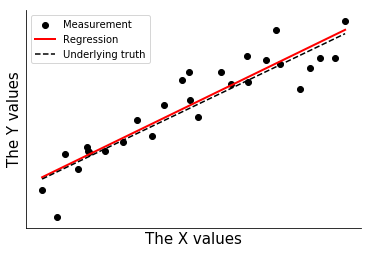

In [6]:
#with plt.xkcd():
fig,ax = plt.subplots(1,1)

p1 = plt.scatter(xdata,ydata,color='k',label='Measurement')
p2 = plt.plot(xdata,ypred,color='r',lw=2,label='Regression')
p3 = plt.plot(xdata,xdata,color='k',ls='--',label='Underlying truth')

handles, labels = ax.get_legend_handles_labels()

plt.legend([handles[i] for i in [2,0,1]],[labels[i] for i in [2,0,1]])
ax.set_xlabel('The X values',size=15)
ax.set_ylabel('The Y values',size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel

t = 1

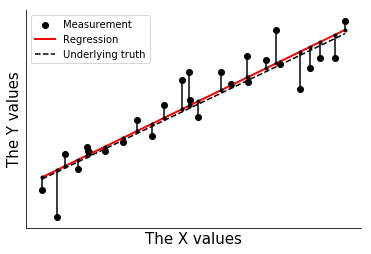

In [90]:
#with plt.xkcd():
fig,ax = plt.subplots(1,1)

p1 = plt.scatter(xdata,ydata,color='k',label='Measurement')
p2 = plt.plot(xdata,ypred,color='r',lw=2,label='Regression')
p3 = plt.plot(xdata,xdata,color='k',ls='--',label='Underlying truth')

for x,y,yp in zip(xdata,ydata,ypred):
    plt.plot((x,x),(y,yp),color='k',marker='.')

handles, labels = ax.get_legend_handles_labels()

plt.legend([handles[i] for i in [2,0,1]],[labels[i] for i in [2,0,1]])
ax.set_xlabel('The X values',size=15)
ax.set_ylabel('The Y values',size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel

t = 1

$$ Y_{new} = X_{new}\beta + \epsilon$$

$$ \delta Y_{new} = t(0.95,n-2)\Bigg\{
                          \frac{Y^TY-\beta^TX^TY}{n-2}\Bigg[X_{new}(X^TX)^{-1}X_{new}^T+1\Bigg]
                          \Bigg\}^{1/2}$$

In [7]:
#Create the linear regression X matrix
xmatrix_first = np.ones_like(xdata) #Constant term
xmatrix = np.concatenate((xmatrix_first,xdata),axis=1) #Add in the linear term

cov = np.dot(xmatrix.T,xmatrix) #Covariance matrix
icov = np.linalg.inv(cov) #Inverse covariance matrix
xty = np.dot(xmatrix.T,ydata[:,np.newaxis,]) #XTy

beta = np.dot(icov,xty) #Coefficients

dof = len(xmatrix_first) - 2 #Degrees of freedom
tdist = sp.stats.t(dof) #T distribution
#T premultiplier, only one standard deviation because n is large. Squared because of how pred_unc is defined below
tmult = tdist.ppf(0.95) ** 2 

sse = (np.dot(ydata.T,ydata) - np.dot(ypred.T,ydata))/(dof) #mean squared error

var_premult = tmult * sse 

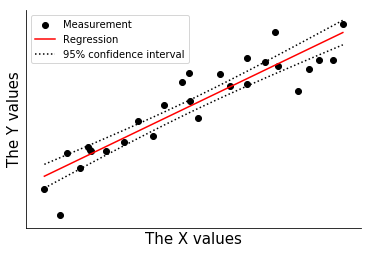

In [8]:
yl = []
yu = []
for row in xmatrix:

    yp = np.dot(row,beta)
    pred_unc = np.sqrt(var_premult*(np.dot(np.dot(row,icov),row.T)))

    yl += [yp - pred_unc]
    yu += [yp + pred_unc]

    #print(pred)

    #print(pred,pred_lower,pred_upper)
lower = np.concatenate(yl)
upper = np.concatenate(yu)

yunc = np.concatenate((yl,yu),axis=1)

fig,ax = plt.subplots()

ax.plot(xdata,ypred,color='r',label='Regression')
ax.plot(xdata,yunc,ls=':',color='k',label='95% confidence interval')
ax.scatter(xdata,ydata,color='k',label='Measurement')

handles, labels = ax.get_legend_handles_labels()

ax.legend([handles[i] for i in [3,0,1]],[labels[i] for i in [3,0,1]])

ax.set_xlabel('The X values',size=15)
ax.set_ylabel('The Y values',size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend()

In [9]:
residual,err,mse = plu.get_residual_stats(ydata,ypred)
residual_cv,err_cv,msecv = plu.get_residual_stats(ydata,y_cv)

num_train = len(xdata)

pseudo_dof = num_train * (1 - np.sqrt(mse/msecv))
bootstrap_weight = np.sqrt(1 - pseudo_dof/num_train)

print(bootstrap_weight)

residual_weighted = residual / bootstrap_weight

0.9594178070226661


In [10]:
samples = 5

residual_boot,boot_indices = plu.bootstrap_data(residual_weighted,samples=samples)
residual_boot = np.squeeze(residual_boot)

boot_data = (residual_boot + ypred).T #boot_data now has the new Y values with shuffled residuals

In [98]:
samples = 2

small_bootstrap = plu.bootstrap_estimator(estimator=linear_regressor,
                                           X=xdata,y=ydata,samples=samples,cv=cv,
                                          )

small_bootstrap.fit()
ypred = small_bootstrap.predict()

boot_data = (small_bootstrap.boot_data_+ypred).T
boot_data.shape
# for row in linear_bootstrap.boot_data_:
#     plt.scatter(xdata,row+ymodel,s=1,color='k')

(28, 2)

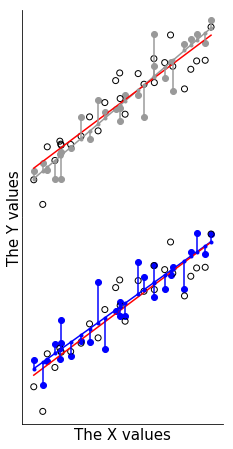

In [104]:
fig,axes = plot_utils.make_grid_plot(samples,1,plotsize=(3,3),sharey=True,sharex=True,
                                     xlabel='The X values',ylabel='The Y values',
                                     ylabel_buffer=0.2,xlabel_buffer=0.25,
                                     gridspec_kw=dict(wspace=0,hspace=0),
                                     subplot_kw=dict(frameon=True))

colors = '0.6','b','r','k','c'
for ax in axes.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
axes.flatten()[-1].spines['bottom'].set_visible(True)

for plot_num,(color,
              yboot,
              est,
              ax) in enumerate(zip(colors,
                                   boot_data.T[:samples],
                                   small_bootstrap.estimators_,
                                   axes.flatten())):
    
    yb = yboot[:,np.newaxis]
    
    ypb = est.predict(xdata)
    
    ax.scatter(xdata,yb,color=color)
    ax.scatter(xdata,ydata,color='k',facecolor='none')
    ax.plot(xdata,ypb,color=color)
    ax.plot(xdata,ypred,color='r')
    ax.set_xticks([])
    ax.set_yticks([])
    
    for x,y,yp in zip(xdata,ypb,yb):
        ax.plot((x,x),(y,yp),color=color,marker='.')

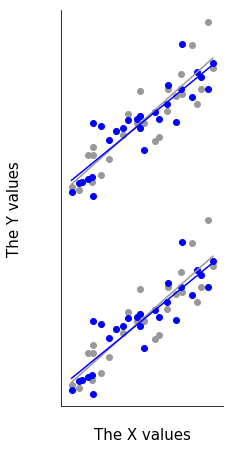

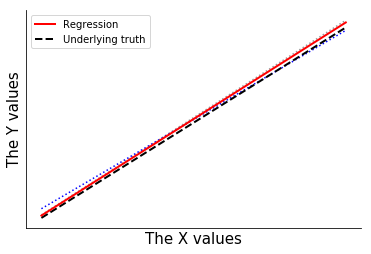

In [84]:
#samples=2
fig,axes = plot_utils.make_grid_plot(samples,1,plotsize=(3,3),sharey=True,sharex=True,
                                     xlabel='The X values',ylabel='The Y values',
                                     gridspec_kw=dict(hspace=0),
                                     subplot_kw=dict(frameon=True))
fig2,ax2=plt.subplots(1,1)

colors = '0.6','b','r','k','c'
ax2.plot(xdata,ypred,color='r',lw=2,zorder=100,label='Regression')
ax2.plot(xdata,xdata,color='k',ls='--',lw=2,zorder=99,label='Underlying truth')

ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_xlabel('The X values',size=15)
ax2.set_ylabel('The Y values',size=15)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

for ax in axes.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
axes.flatten()[-1].spines['bottom'].set_visible(True)

for plot_num,(color,yboot) in enumerate(zip(colors,boot_data.T[:samples])):
    
    yb = yboot[:,np.newaxis]
    
    #fig,ax = plt.subplots(1,1)
    regr.fit(xdata,yb)
    ypb = regr.predict(xdata)
    
    #print('{},{}'.format(plot_num-1,plot_num+1))
    
    for ax in axes.flatten()[[plot_num-1,plot_num]]:
        ax.scatter(xdata,yb,color=color)
        ax.plot(xdata,ypb,color=color)
        ax.set_xticks([])
    if color=='k':
        ax2.plot(xdata,ypb,color=color,ls=':',label='Bootstrap regression')
    else:
        ax2.plot(xdata,ypb,color=color,ls=':')

ax = axes.flatten()[0]
ax.set_yticks([])
#ax.set_ylabel('The Y values')
#ax = axes[2]
#ax.set_xlabel('The X values')


ax2.legend()


In [12]:
samples = 1000

linear_bootstrap = plu.bootstrap_estimator(estimator=linear_regressor,
                                           X=xdata,y=ydata,samples=samples,cv=cv,
                                          )

linear_bootstrap.fit()

ypred,cpb,bounds,error, = linear_bootstrap.bootstrap_uncertainty_bounds()

#lbt_out = plu.bootstrap(xdata=xdata,ydata=np.squeeze(ydata),
#                        PLS_model=regr,cv_object=cv,samples=samples)
#rcv,ecv,msecv,cpb,cpt = lbt_out

In [13]:
for est in linear_bootstrap.estimators_:
    print(est.predict(linear_bootstrap.data_).shape)
    break

(28,)


In [14]:
cpb.shape

(1000, 28)

In [15]:
linear_bootstrap.boot_data_.shape

(1000, 28)

In [16]:
linear_bootstrap.boot_indices_.shape

(1000, 28)

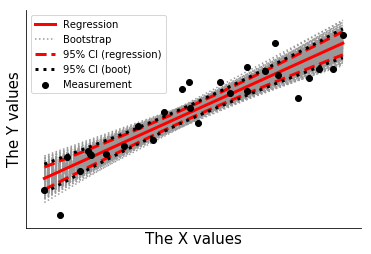

In [17]:
fig2,ax2=plt.subplots(1,1)

for ypb in cpb:
    ax2.plot(xdata,ypb,color='0.6',ls=':',zorder=0)

ax2.plot(xdata,ypred,color='r',lw=3,label='Regression',zorder=3)
ax2.plot(xdata,yunc,ls='--',color='r',lw=3,label='95% CI (regression)',zorder=3)
ax2.plot(xdata,ypb,color='0.6',ls=':',label='Bootstrap',zorder=-1)

ax2.plot(xdata,bounds.T,ls=':',color='k',lw=3,label='95% CI (boot)',zorder=4)

ax2.scatter(xdata,ydata,color='k',label='Measurement',zorder=5)

ax2.set_xlabel('The X values',size=15)
ax2.set_ylabel('The Y values',size=15)

ax2.set_xticks([])
ax2.set_yticks([])


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#ax2.legend()

handles, labels = ax2.get_legend_handles_labels()

ax2.legend([handles[i] for i in [0,3,1,4,6]],[labels[i] for i in [0,3,1,4,6]])

t = 1

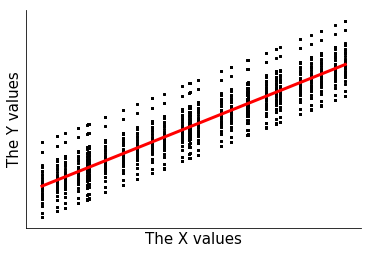

In [58]:
fig3,ax3=plt.subplots(1,1)

ax3.plot(xdata,ypred,color='r',lw=3,label='Regression',zorder=3)

ymodel = linear_bootstrap.base_predict(xdata)
for row in linear_bootstrap.boot_data_:
    plt.scatter(xdata,row+ymodel,s=1,color='k')

ax3.set_xlabel('The X values',size=15)
ax3.set_ylabel('The Y values',size=15)

ax3.set_xticks([])
ax3.set_yticks([])


ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

In [30]:
bootstrap_x = linear_bootstrap.data_[linear_bootstrap.boot_indices_]
bootstrap_y = linear_bootstrap.ydata_[linear_bootstrap.boot_indices_]

In [29]:
bootstrap_x.shape

(1000, 28, 1)

In [31]:
bootstrap_y.shape

(1000, 28)

In [34]:
bootstrap_y

array([[6.57, 6.14, 3.7 , ..., 8.29, 8.05, 4.69],
       [5.59, 7.22, 6.02, ..., 5.17, 6.43, 5.59],
       [4.74, 6.14, 4.69, ..., 7.29, 7.11, 6.57],
       ...,
       [6.02, 4.69, 7.27, ..., 7.22, 7.29, 4.76],
       [8.29, 8.29, 7.11, ..., 7.11, 6.57, 7.02],
       [6.62, 6.43, 8.29, ..., 6.14, 6.89, 4.86]])

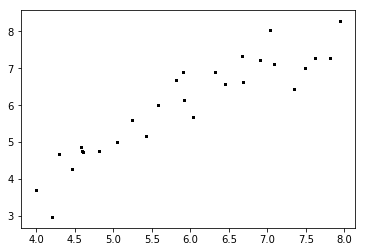

In [32]:
for x,y in zip(bootstrap_x,bootstrap_y):
    plt.scatter(x,y,s=1,color='k')

In [36]:
import sklearn.ensemble as skens

In [40]:
bagger = skens.BaggingRegressor(base_estimator=linear_regressor(),n_estimators=1000)

In [41]:
bagger.fit(xdata,ydata)

BaggingRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [52]:
y = np.stack([est.predict(xdata) for est in bagger.estimators_])
bounds_boot = np.array([np.percentile(y,2.5,axis=0),np.percentile(y,97.5,axis=0),])

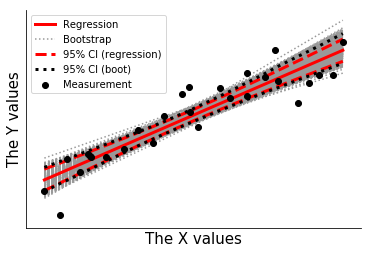

In [53]:
fig2,ax2=plt.subplots(1,1)

for ypb in y:
    ax2.plot(xdata,ypb,color='0.6',ls=':',zorder=0)

ax2.plot(xdata,ypred,color='r',lw=3,label='Regression',zorder=3)
ax2.plot(xdata,yunc,ls='--',color='r',lw=3,label='95% CI (regression)',zorder=3)
ax2.plot(xdata,ypb,color='0.6',ls=':',label='Bootstrap',zorder=-1)

ax2.plot(xdata,bounds_boot.T,ls=':',color='k',lw=3,label='95% CI (boot)',zorder=4)

ax2.scatter(xdata,ydata,color='k',label='Measurement',zorder=5)

ax2.set_xlabel('The X values',size=15)
ax2.set_ylabel('The Y values',size=15)

ax2.set_xticks([])
ax2.set_yticks([])


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#ax2.legend()

handles, labels = ax2.get_legend_handles_labels()

ax2.legend([handles[i] for i in [0,3,1,4,6]],[labels[i] for i in [0,3,1,4,6]])

t = 1

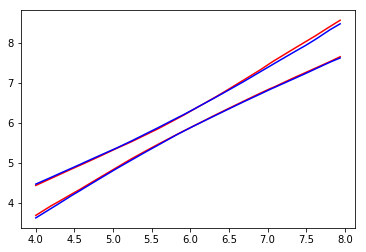

In [54]:
plt.plot(xdata,bounds_boot.T,color='r')
plt.plot(xdata,bounds.T,color='b')

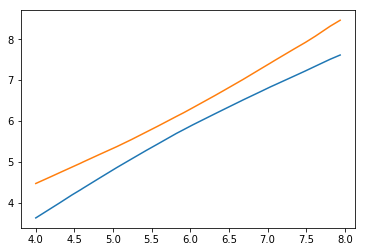

In [49]:
plt.plot(xdata,bounds.T)

In [56]:
bounds - bounds_boot

array([[-0.06328555, -0.06512044, -0.05458045, -0.03636374, -0.03077112,
        -0.0311242 , -0.03041983, -0.02815061, -0.02536537, -0.03199606,
        -0.02434907, -0.02167328, -0.00633415, -0.00777106, -0.00687011,
        -0.00298801, -0.01195294, -0.01373795, -0.01515883, -0.01531611,
        -0.02116249, -0.01760877, -0.01570994, -0.02540948, -0.02349817,
        -0.01936997, -0.01534212, -0.03108975],
       [ 0.03324578,  0.02698006,  0.02523654,  0.0208345 ,  0.02129458,
         0.02303092,  0.02344775,  0.02051574,  0.00908304,  0.01906237,
         0.02297079,  0.0271482 ,  0.01843347,  0.01286657,  0.0125714 ,
         0.00534348, -0.01012879, -0.01703969, -0.03816321, -0.03797361,
        -0.04901688, -0.06938489, -0.07263878, -0.08545337, -0.09374966,
        -0.08957965, -0.08052575, -0.0887368 ]])